In [304]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

In [305]:
validate_answers = pd.read_csv('./data/validate_answers.tsv', delimiter='\t')
validate = pd.read_csv('./data/validate.tsv', delimiter='\t')
users = pd.read_csv('./data/users.tsv', delimiter='\t')
history = pd.read_csv('./data/history.tsv', delimiter='\t')

### History

In [8]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

In [74]:
history['time'] = history.hour.map(lambda x: x % 24)

In [75]:
history['day_of_week'] = history.hour.map(lambda x: (x // 24) % 7 + 1)

In [68]:
history = history.sort_values(by=['hour']).reset_index(drop=True)

In [76]:
history_and_users = history.merge(users, on='user_id')

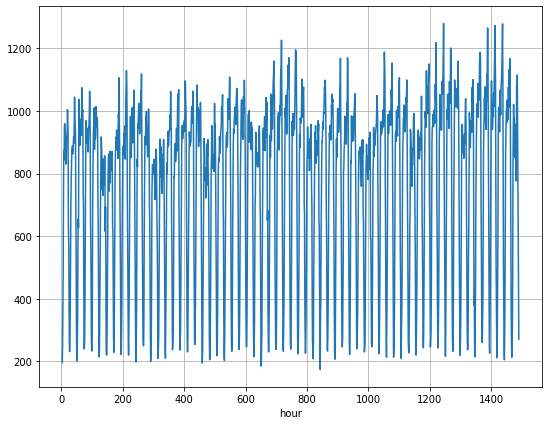

In [87]:
plt.figure(figsize=(9,7))
history_and_users \
    .groupby(['hour'])['user_id'] \
    .count() \
    .plot() 

plt.grid()

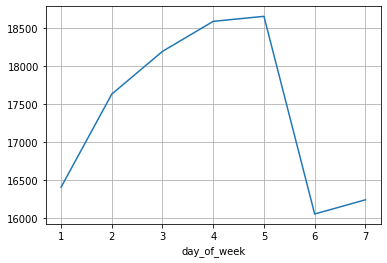

In [85]:
history_and_users[history_and_users.hour < 168] \
    .groupby(['day_of_week'])['user_id'] \
    .count() \
    .plot() 

plt.grid()

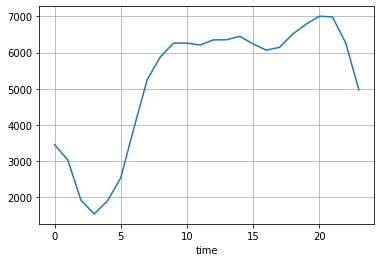

In [84]:
history_and_users[(history_and_users.hour > 168) & (history_and_users.hour < 2 * 168)] \
    .groupby(['time'])['user_id'] \
    .count() \
    .plot() 

plt.grid()

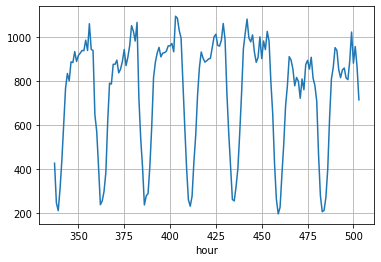

In [83]:
history_and_users[(history_and_users.hour > 2*168) & (history_and_users.hour < 3 * 168)] \
    .groupby(['hour'])['user_id'] \
    .count() \
    .plot() 

plt.grid()

## Target

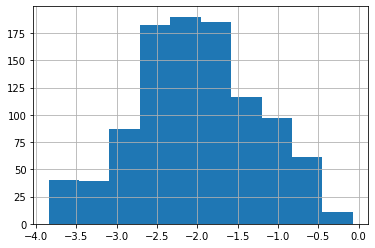

In [108]:
def box_cox(x, lmbda):
    return (x ** lmbda - 1) / lmbda

def anti_box_cox(x, lmbda):
    return (lmbda * x + 1) ** (1 / lmbda)

box_cox(validate_answers.at_least_one, .26).hist()

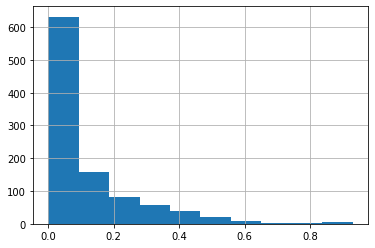

In [164]:
validate_answers.at_least_one.hist()

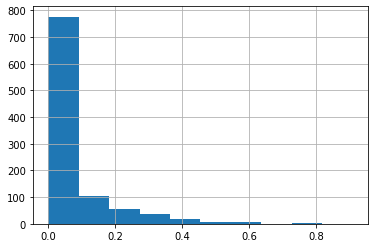

In [165]:
validate_answers.at_least_two.hist()

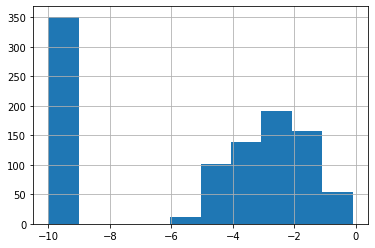

In [166]:
box_cox(validate_answers.at_least_two, 0.1).hist()

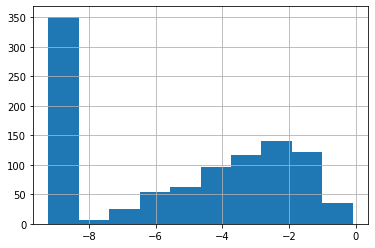

In [101]:
np.log(validate_answers.at_least_two + 0.0001).hist()

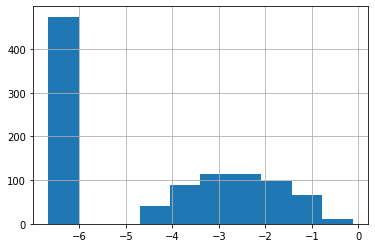

In [170]:
box_cox(validate_answers.at_least_three, 0.15).hist()

### Validataion

In [93]:
df = pd.concat([validate, validate_answers], axis=1)

In [96]:
df = df.sort_values(by=['hour_start']).reset_index(drop=True)

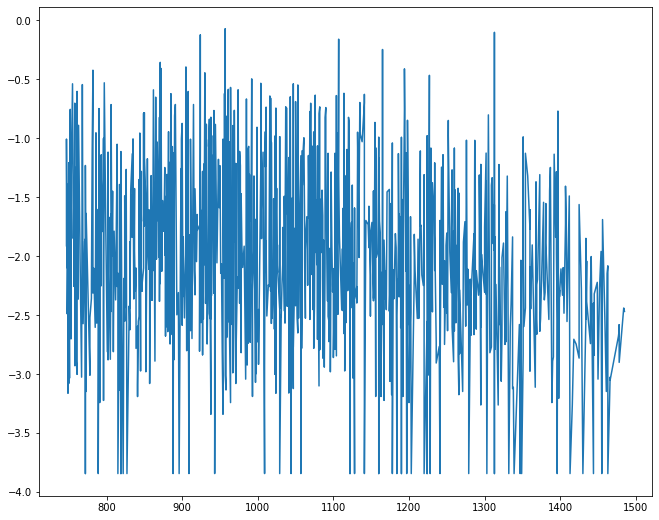

In [114]:
plt.figure(figsize=(11, 9))
plt.plot(df.hour_start, box_cox(df.at_least_one, .26))
#plt.plot(df.hour_start, df.at_least_two)
#plt.plot(df.hour_start, df.at_least_three)

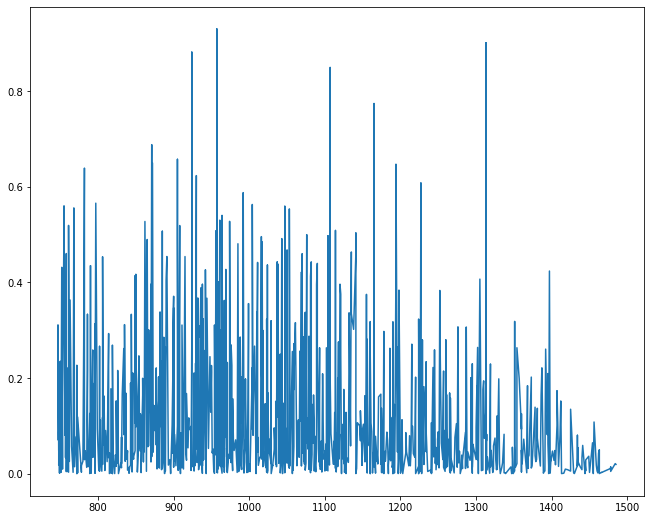

In [116]:
plt.figure(figsize=(11, 9))
plt.plot(df.hour_start, df.at_least_one)
#plt.plot(df.hour_start, df.at_least_two)
#plt.plot(df.hour_start, df.at_least_three)

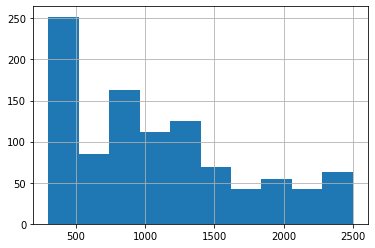

In [122]:
df.audience_size.hist()

### Features

In [306]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

history['time'] = history.hour.map(lambda x: x % 24)

history['day_of_week'] = history.hour.map(lambda x: (x // 24) % 7 + 1)

In [307]:
def aggregate_history(history_merged_users):
    """
    Какую инфу можно вытащить из history (publisher-user_id)?
    1) Агрегаты
    2) ALS
    """
    
    # Временные признаки
    df = history_merged_users.copy()
    df['time'] = df['hour'].map(lambda x: x % 24)
    df['day_of_week'] = df['hour'].map(lambda x: (x // 24) % 7 + 1)
    df['is_weekend'] = df['day_of_week'].map(lambda x: int(x in [6, 7]))
    df['time_harmonic_0'] = make_harmonic_features(df['hour'])[0]
    df['time_harmonic_1'] = make_harmonic_features(df['hour'])[1]
    
    # Аггрегаты по user_id
    users = df \
      .groupby(['user_id']) \
      [['cpm', 'is_weekend', 'time', 'time_harmonic_0', 'time_harmonic_1', 'publisher']] \
      .mean()
    users.columns = ['user_mean_' + x for x in users.columns]
    users['user_id'] = users.index
    users = users.reset_index(drop=True)
    
    user_unique_publishers = df \
      .groupby(['user_id'])['publisher'] \
      .apply(set) \
      .to_frame()
    
    user_unique_publishers['user_unique_publishers_cnt'] = \
        user_unique_publishers['publisher'].map(len)
    user_unique_publishers = user_unique_publishers.drop(columns='publisher')
    user_unique_publishers['user_id'] = user_unique_publishers.index
    user_unique_publishers = user_unique_publishers.reset_index(drop=True)
    
    # Аггрегаты по publisher 
    publishers = df \
      .groupby(['publisher']) \
      [['time', 'time_harmonic_0', 'time_harmonic_1',  'is_weekend', \
        'cpm', 'user_id', 'sex', 'age', 'city_id']] \
      .mean()
    publishers.columns = ['publisher_mean_' + x for x in publishers.columns]
    publishers['publisher'] = publishers.index
    publishers = publishers.reset_index(drop=True)
    
    publisher_unique_users = df \
      .groupby(['publisher'])['user_id'] \
      .apply(set) \
      .to_frame()
    
    publisher_unique_users['publisher_unique_users_cnt'] = \
        publisher_unique_users['user_id'].map(len)
    publisher_unique_users = publisher_unique_users.drop(columns='user_id')
    publisher_unique_users['publisher'] = publisher_unique_users.index
    publisher_unique_users = publisher_unique_users.reset_index(drop=True)
    
    
    return (users.merge(user_unique_publishers, on='user_id'), \
           publishers.merge(publisher_unique_users, on='publisher'))

In [308]:
(users_insights, publishers) = aggregate_history(history.merge(users))

In [309]:
def merge_history(data, users, publishers):
    df = data.copy()
    df['id'] = df.index
    
    # Временные признаки
    df['duration'] = df['hour_end'] - df['hour_start']
    df['publishers_size'] = df['publishers'].map(lambda x: len(x.split(',')))
    df['time_start'] = df['hour_start'].map(lambda x: x % 24)
    df['time_end'] = df['hour_end'].map(lambda x: x % 24)
    df['day_of_week_start'] = df['hour_start'].map(lambda x: (x // 24) % 7 + 1)
    df['day_of_week_end'] = df['hour_end'].map(lambda x: (x // 24) % 7 + 1)
    df['day_start_is_weekend'] = df['day_of_week_start'].map(lambda x: int(x in [6, 7]))
    df['day_end_is_weekend'] = df['day_of_week_end'].map(lambda x: int(x in [6, 7]))
    df['time_start_harmonic_0'] = make_harmonic_features(df['hour_start'])[0]
    df['time_start_harmonic_1'] = make_harmonic_features(df['hour_start'])[1]
    df['time_end_harmonic_0'] = make_harmonic_features(df['hour_end'])[0]
    df['time_end_harmonic_1'] = make_harmonic_features(df['hour_end'])[1]
 
    # Агрегация по пользователям
    df['user_ids'] = df['user_ids'].map(lambda row: [int(x) for x in row.split(',')])
    data_user_mean = df.explode('user_ids') \
        .merge(users, left_on='user_ids', right_on='user_id', how='left') \
        .groupby(['id']) \
        [['sex', 'age', 'city_id', 'user_mean_cpm',
          'user_mean_is_weekend', 'user_mean_time',
          'user_mean_time_harmonic_0', 'user_mean_time_harmonic_1',
          'user_mean_publisher', 'user_unique_publishers_cnt']] \
        .mean()
    
    data_user_mean['id'] = data_user_mean.index
    data_user_mean = data_user_mean.reset_index(drop=True)
    
    # Агрегация по площадкам
    df['publishers'] = df['publishers'].map(lambda row: [int(x) for x in row.split(',')])
    data_publisher_mean = df.explode('publishers') \
        .merge(publishers, left_on='publishers', right_on='publisher', how='left') \
        .groupby(['id']) \
        [['publisher_mean_time', 'publisher_mean_time_harmonic_0',
          'publisher_mean_time_harmonic_1', 'publisher_mean_is_weekend',
          'publisher_mean_cpm', 'publisher_mean_user_id', 'publisher_mean_sex',
          'publisher_mean_age', 'publisher_mean_city_id', 'publisher_unique_users_cnt']] \
        .mean()
    
    data_publisher_mean['id'] = data_publisher_mean.index
    data_publisher_mean = data_publisher_mean.reset_index(drop=True)
    
    return df.merge(data_user_mean, on='id').merge(data_publisher_mean, on='id')

In [310]:
df = merge_history(validate, users.merge(users_insights, how='left'), publishers)

In [359]:
features = ['duration', 'publishers_size', 'time_start',
       'time_end', 'day_of_week_start', 'day_of_week_end',
       'day_start_is_weekend', 'day_end_is_weekend', 'time_start_harmonic_0',
       'time_start_harmonic_1', 'time_end_harmonic_0', 'time_end_harmonic_1', 
       'cpm', 'hour_start', 'hour_end', 'audience_size',
       'sex', 'age', 'city_id', 'user_mean_cpm',
       'user_mean_is_weekend', 'user_mean_time', 'user_mean_time_harmonic_0',
       'user_mean_time_harmonic_1', 'user_mean_publisher',
       'user_unique_publishers_cnt', 'publisher_mean_time',
       'publisher_mean_time_harmonic_0', 'publisher_mean_time_harmonic_1',
       'publisher_mean_is_weekend', 'publisher_mean_cpm',
       'publisher_mean_user_id', 'publisher_mean_sex', 'publisher_mean_age',
       'publisher_mean_city_id', 'publisher_unique_users_cnt']

df = df[features]

In [373]:
X, y = df.values, validate_answers.at_least_one.values
y = box_cox(y, .26)

### Model

In [374]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold

def s_mape(y, y_hat, s=False):
    if s:
        return np.mean(200 * np.abs(y - y_hat) / (y + y_hat))
    else:
        return np.mean(100 * np.abs(y - y_hat) / np.abs(y))

def run_cv(X, y, pars, cat_feature=None, num_folds=3, score=r2_score, print_plots=False, drop_noise=False):
    
    train_scores_hist = []
    test_scores_hist = []
    
    model = LGBMRegressor(**pars)

    folds = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    for i, (train_index, test_index) in enumerate(folds.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                      verbose=100,
                      early_stopping_rounds=100)

        
        if drop_noise: 
            train_residual = np.abs(y_train.flatten() - y_train_hat)
            plt.figure()
            sns.distplot(y_train.flatten() - y_train_hat)
            plt.title('Распределение остатков')
            
            X_train = X_train[train_residual < 1.5]
            y_train = y_train[train_residual < 1.5]
            model.fit(X_train, y_train, 
                      #cat_features=list(range(len(cat_features))),
                      eval_set=(X_test, y_test),
                      verbose=False)
            y_train_hat = model.predict(X_train)
            
        y_train_hat = model.predict(X_train)
        y_test_hat = model.predict(X_test)
        train_scores_hist.append(score(y_train, y_train_hat))
        test_scores_hist.append(score(y_test, y_test_hat))
        
        print('Test MAE: {} MAPE: {} SMAPE: {}' \
              .format(mean_absolute_error(y_test, y_test_hat), \
                      s_mape(y_test, y_test_hat),
                      s_mape(y_test, y_test_hat, s=True)))
                
        if print_plots:
            print('Fold num {}'.format(i))
            plot_residual(y_train.flatten(), y_train_hat, i=i+1, title='Остатки на трейне')
            plot_residual(y_test.flatten(), y_test_hat, i=i+1, title='Остатки на тесте')
            plot_hist(y_test.flatten(), y_test_hat, i=i+1, title='Распределение y_true и y_hat на тесте')

            print('-------------------\n')
        
    return train_scores_hist, test_scores_hist, model
    

In [375]:
pars = {'boosting_type':'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 31}

train_scores_hist, test_scores_hist, model = run_cv(X, y, pars, num_folds=5)

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00942514	valid_1's l2: 0.0567733
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.00942514	valid_1's l2: 0.0567733
Test MAE: 0.18784411123832606 MAPE: 10.784991099980665 SMAPE: -10.182973735849455
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00923164	valid_1's l2: 0.0651076
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.00923164	valid_1's l2: 0.0651076
Test MAE: 0.17426975624198124 MAPE: 10.187330926387014 SMAPE: -9.600950625524643
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0100966	valid_1's l2: 0.067242
Did not meet early stopping. Best iteration is:
[100]	training's l2: 0.0100966	valid_1's l2: 0.067242
Test MAE: 0.18668280450971012 MAPE: 13.36257138691893 SMAPE: -10.495194976601795
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00996176	

In [376]:
test_scores_hist

[0.8989800034284422,
 0.8896860516865812,
 0.9007053098807818,
 0.9009251242803463,
 0.9000509340956842]

In [377]:
sorted([x for x in zip(features, model.feature_importances_)], key=lambda x: x[1], reverse=True)

[('cpm', 344),
 ('duration', 309),
 ('publisher_unique_users_cnt', 301),
 ('user_mean_cpm', 223),
 ('user_unique_publishers_cnt', 223),
 ('publishers_size', 211),
 ('user_mean_publisher', 80),
 ('user_mean_time', 78),
 ('publisher_mean_cpm', 78),
 ('publisher_mean_age', 74),
 ('publisher_mean_time_harmonic_0', 70),
 ('time_start_harmonic_0', 69),
 ('time_end_harmonic_0', 61),
 ('user_mean_time_harmonic_1', 59),
 ('audience_size', 55),
 ('publisher_mean_time_harmonic_1', 55),
 ('hour_start', 54),
 ('time_end_harmonic_1', 52),
 ('sex', 52),
 ('age', 52),
 ('publisher_mean_city_id', 51),
 ('user_mean_time_harmonic_0', 45),
 ('time_start', 44),
 ('city_id', 43),
 ('time_end', 36),
 ('time_start_harmonic_1', 36),
 ('publisher_mean_user_id', 35),
 ('publisher_mean_sex', 35),
 ('user_mean_is_weekend', 32),
 ('publisher_mean_time', 30),
 ('publisher_mean_is_weekend', 26),
 ('hour_end', 21),
 ('day_of_week_end', 17),
 ('day_of_week_start', 16),
 ('day_start_is_weekend', 0),
 ('day_end_is_weeken